<a href="https://colab.research.google.com/github/dbtronics/COMP551---Miniproject-3-Classification-of-Image-Data-/blob/main/Group_18_Miniproject_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

Train image shape:  (60000, 28, 28)
Train label shape:  (60000,)

Test image shape:  (10000, 28, 28)
Test label shape:  (10000,)


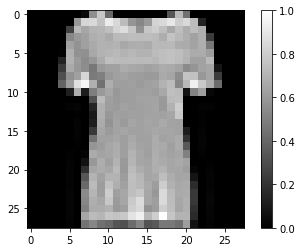

In [3]:
mnist_dataset = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

print("Train image shape: ", train_images.shape)
print("Train label shape: ", train_labels.shape)
print("\nTest image shape: ", test_images.shape)
print("Test label shape: ", test_labels.shape)

train_images = train_images/255
test_images = test_images/255

plt.imshow(train_images[10], cmap='gray')
plt.colorbar()
# plt.grid(False)
plt.show()